# MLP

In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn import metrics

## Doc2vec - MLP

In [2]:
#Datuak path
datuak='./CSV/preprocess.csv'
gorde='./CSV/'

In [3]:
#datuak kargatu
df=pd.read_csv(gorde+'preprocess.csv')
df.head()

,post,Fraudulent
0,marketing intern u ny new york marketing were ...,0
1,customer service cloud video production nz auc...,0
2,commissioning machinery assistant cma u ia wev...,0
3,account executive washington dc u dc washingto...,0
4,bill review manager u fl fort worth spotsource...,0


In [4]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
print(train.shape[0])
print(test.shape[0])

12516
5364


Doc2Vec

In [5]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['post']), tags=[r.Fraudulent]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['post']), tags=[r.Fraudulent]), axis=1)

In [8]:
#vectorsize=300
vectorsize=150
#mincount=1
mincount=2

In [9]:
model_dbow = Doc2Vec(dm=0, vector_size=vectorsize, negative=5, hs=0, min_count=mincount, sample = 0)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 12516/12516 [00:00<00:00, 2293399.25it/s]


In [10]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 12516/12516 [00:00<00:00, 2548345.09it/s]


CPU times: user 2min 28s, sys: 1.16 s, total: 2min 29s
Wall time: 52.4 s


In [11]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors 

In [12]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [13]:
#Importing MLPClassifier
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

In [14]:
#Fitting the training data to the network
classifier.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [15]:
#Predicting y for X_val
y_pred = classifier.predict(X_test)

In [16]:
#Importing Confusion Matrix
from sklearn.metrics import confusion_matrix
#Comparing the predictions against the actual observations in y_val
cnf_matrix = confusion_matrix(y_pred, y_test)
cnf_matrix

array([[5093,  271],
       [   0,    0]])

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5093
           1       0.00      0.00      0.00       271

    accuracy                           0.95      5364
   macro avg       0.47      0.50      0.49      5364
weighted avg       0.90      0.95      0.92      5364



/home/maialen/anaconda3/envs/datumeatzaritza/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 257.44, 'Predicted label')

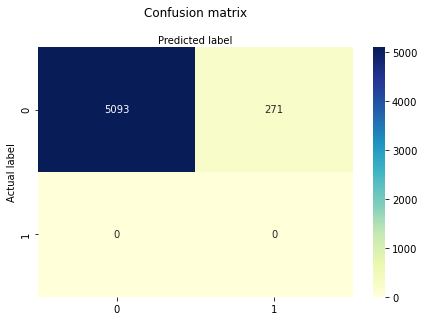

In [18]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [19]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9494780014914244
Precision: 0.0
Recall: 0.0


/home/maialen/anaconda3/envs/datumeatzaritza/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


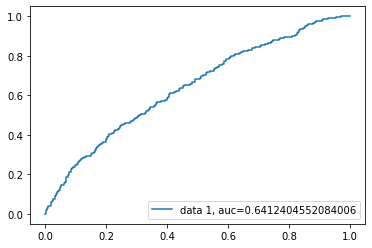

In [20]:
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## TFIDF - MLP

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
#Datuak path
datuak='./CSV/preprocess.csv'
gorde='./CSV/'
#datuak kargatu
df=pd.read_csv(gorde+'preprocess.csv')
df.head()

,post,Fraudulent
0,marketing intern u ny new york marketing were ...,0
1,customer service cloud video production nz auc...,0
2,commissioning machinery assistant cma u ia wev...,0
3,account executive washington dc u dc washingto...,0
4,bill review manager u fl fort worth spotsource...,0


In [23]:
y=df.Fraudulent.values

In [24]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df.post.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)

In [25]:
#TFIDF errepresentazio desberdinak lortzeko
#mindf=3
mindf=1

In [26]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=mindf,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [27]:
X_train=xtrain_tfv
y_train=ytrain
X_test=xvalid_tfv
y_test=yvalid
print(X_train.shape[0])
print(X_test.shape[0])

12516
5364


In [28]:
#Importing MLPClassifier
from sklearn.neural_network import MLPClassifier

#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

In [ ]:
#Fitting the training data to the network
classifier.fit(X_train, y_train)

In [ ]:
#Predicting y for X_val
y_pred = classifier.predict(X_test)

In [ ]:
#Predicting y for X_val
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

In [ ]:
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))